<a href="https://colab.research.google.com/github/diwakar-vsingh/DeepLabV3-TensorFlow2.x/blob/master/deeplabv3%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# DeepLabV3+

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to assign semantic labels to every pixel in an image using Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation. The model is based on TF repo

## Import TensorFlow and other libraries

In [ ]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

## Load the weights

In [ ]:
WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"

In [ ]:
img_height = 224
img_width = 224

## Model

In [ ]:
input_shape=(img_height, img_width, 3)
classes=21
output_strides=16
activation=None
weights="pascal_voc"

In [ ]:
def ASPP_layers(x, filters, prefix, rate=1, epsilon=1e-5):
  layer = tf.keras.Sequential(
      [
       tf.keras.layers.DepthwiseConv2D(3, padding='same', use_bias=False, dilation_rate=rate),
       tf.keras.layers.BatchNormalization(epsilon=epsilon),
       tf.keras.layers.Activation("relu"),
       tf.keras.layers.Conv2D(filters, 1, padding='same', use_bias=False),
       tf.keras.layers.BatchNormalization(epsilon=epsilon),
       tf.keras.layers.Activation("relu")
      ], name=prefix)

  return layer(x)

def image_feature(x, prefix, epsilon=1e-5):
  height, width = x.shape[1:3]
  layer = tf.keras.Sequential(
      [
       tf.keras.layers.AveragePooling2D(pool_size=(height, width)),
       tf.keras.layers.Conv2D(256, 1, padding="same", use_bias=False),
       tf.keras.layers.BatchNormalization(name="image_pooling_bn", epsilon=epsilon),
       tf.keras.layers.Activation("relu"),
       tf.keras.layers.experimental.preprocessing.Resizing(height, width, interpolation='bilinear')
       ], name=prefix)(x)

  return layer

In [ ]:
def _depthwise_conv_block(x, filters, prefix, strides=1, rate=1, 
                          start_with_relu=True, depth_act=False, epsilon=1e-3):
  
  """
  Adds a depthwise convolution block.
  A depthwise convolution block consists of a depthwise conv,
  batch normalization, relu, pointwise convolution,
  batch normalization and relu activation.
  
  Arguments:
    x: Input tensor
    filters: No. of filters in pointwise convolution
    prefix: prefix before name
    strides: stride at depthwise conv
    rate: atrous rate for depthwise convolution
  Returns:
    Output tensor of block.
  """
  layers = tf.keras.Sequential(name=prefix)
  if start_with_relu:
    layers.add(tf.keras.layers.Activation('relu'))

  layers.add(tf.keras.layers.DepthwiseConv2D(3, strides=strides, padding='same', 
                                      use_bias=False, dilation_rate=rate))
  layers.add(tf.keras.layers.BatchNormalization(epsilon=epsilon))
  layers.add(tf.keras.layers.Activation("relu"))
  layers.add(tf.keras.layers.Conv2D(filters, 1, strides=1, padding='same', use_bias=False))
  layers.add(tf.keras.layers.BatchNormalization(epsilon=epsilon))

  if depth_act:
    layers.add(tf.keras.layers.Activation("relu"))

  return layers(x)

def conv_layer(x, filters, kernel, prefix, strides=1, rate=1, epsilon=1e-3, depth_act=True):
  layers = tf.keras.Sequential(name=prefix)
  layers.add(tf.keras.layers.Conv2D(filters, kernel, strides=strides,
                                    padding='same', use_bias=False, dilation_rate=rate))
  layers.add(tf.keras.layers.BatchNormalization(epsilon=epsilon))

  if depth_act:
    layers.add(tf.keras.layers.Activation("relu"))

  return layers(x)

In [ ]:
dilation_rates = (1,2)
atrous_rates = (6, 12, 18)

img_input = tf.keras.Input(shape=input_shape)

## Entry flow
x = conv_layer(img_input, 32, 3, "entry_flow_conv1", strides=2)
x = conv_layer(x, 64, 3, "entry_flow_conv2", strides=1)
residual = conv_layer(x, 128, 1, "residual1", strides=2, depth_act=False)

# Block 1
x = _depthwise_conv_block(x, 128, "entry_flow_block1_1", strides=1, start_with_relu=False)
x = _depthwise_conv_block(x, 128, "entry_flow_block1_2", strides=1)
x = _depthwise_conv_block(x, 128, "entry_flow_block1_3", strides=2)
x = tf.keras.layers.Add()([x, residual])
residual = conv_layer(x, 256, 1, "residual2", strides=2, depth_act=False)

# Block 2
x = _depthwise_conv_block(x, 256, "entry_flow_block2_1", strides=1)
x = _depthwise_conv_block(x, 256, "entry_flow_block2_2", strides=1)
x = _depthwise_conv_block(x, 256, "entry_flow_block2_3", strides=2)
low_level_feat = x
x = tf.keras.layers.Add()([x, residual])
residual = conv_layer(x, 728, 1, "residual3", strides=2, depth_act=False)

# Block 3
x = _depthwise_conv_block(x, 728, "entry_flow_block3_1", strides=1)
x = _depthwise_conv_block(x, 728, "entry_flow_block3_2", strides=1)
x = _depthwise_conv_block(x, 728, "entry_flow_block3_3", strides=2)
x = tf.keras.layers.Add()([x, residual])

# Middle Flow
for i in range(16):
  residual = x
  x = _depthwise_conv_block(x, 728, "middle_flow_block%d_1" % (i+4))
  x = _depthwise_conv_block(x, 728, "middle_flow_block%d_2" % (i+4))
  x = _depthwise_conv_block(x, 728, "middle_flow_block%d_3" % (i+4))
  x = tf.keras.layers.Add()([x, residual])

# Exit Flow
residual = conv_layer(x, 1024, 1, "residual4", strides=2, depth_act=False)

x = _depthwise_conv_block(x, 728, "exit_flow_block20_1", strides=1, rate=dilation_rates[0])
x = _depthwise_conv_block(x, 1024, "exit_flow_block20_2", strides=1, rate=dilation_rates[0])
x = _depthwise_conv_block(x, 1024, "exit_flow_block20_3", strides=2, rate=dilation_rates[0])
x = tf.keras.layers.Add()([x, residual])

x = _depthwise_conv_block(x, 1536, "exit_flow_block21_1", rate=dilation_rates[1])
x = _depthwise_conv_block(x, 1536, "exit_flow_block21_2", rate=dilation_rates[1])
x = _depthwise_conv_block(x, 2048, "exit_flow_block21_3", rate=dilation_rates[1], depth_act=True)

a0 = tf.keras.Sequential(
    [
     tf.keras.layers.Conv2D(256, 1, padding="same", use_bias=False),
     tf.keras.layers.BatchNormalization(epsilon=1e-5),
     tf.keras.layers.Activation("relu")
    ], name="ASPP0")(x)
a1 = ASPP_layers(x, 256, "ASPP1", rate=atrous_rates[0], epsilon=1e-5)
a2 = ASPP_layers(x, 256, "ASPP2", rate=atrous_rates[1], epsilon=1e-5)
a3 = ASPP_layers(x, 256, "ASPP3", rate=atrous_rates[2], epsilon=1e-5)
a4 = image_feature(x, "image_pooling", epsilon=1e-5)

x = tf.keras.layers.Concatenate(name="image_feature")([a4, a0, a1, a2, a3])
x = conv_layer(x, 256, 1, "concat_proj", epsilon=1e-5)

In [ ]:
x = tf.keras.layers.experimental.preprocessing.Resizing(
    4*x.shape[1], 4*x.shape[2], interpolation='bilinear')(x)

low_level_feat = conv_layer(low_level_feat, 48, 1, "feature_proj", epsilon=1e-5)
# low_level_feat = tf.keras.layers.Conv2D(48, 1, padding="same", use_bias=False, name="feature_proj0")(low_level_feat)
# low_level_feat = tf.keras.layers.BatchNormalization(name='feature_proj0_bn', epsilon=1e-5)(low_level_feat)
# low_level_feat = tf.keras.layers.Activation("relu", name="feature_proj0_act")(low_level_feat)
x = tf.keras.layers.Concatenate(name="skip_concat")([x, low_level_feat])

x = _depthwise_conv_block(x, 256, "decoder_1", start_with_relu=False, depth_act=True, epsilon=1e-5)
x = _depthwise_conv_block(x, 256, "decoder_2", start_with_relu=False, depth_act=True, epsilon=1e-5)

x = tf.keras.layers.experimental.preprocessing.Resizing(
    4*x.shape[1], 4*x.shape[2], interpolation='bilinear')(x)

if (weights=='pascal_voc' and classes==21) or (weights=="cityscapes" and classes==19):
  last_layer = "logits_semantics"
else:
  last_layer = "custom_logits_semantics"

x = tf.keras.layers.Conv2D(classes, 1, padding="same", name=last_layer)(x)
x = tf.keras.layers.experimental.preprocessing.Resizing(
    img_height, img_width, interpolation='bilinear')(x)

model = tf.keras.Model(inputs=img_input, outputs=x, name="DeepLabv3+")

In [ ]:
# load weights
if weights == 'pascal_voc':
  weights_path = tf.keras.utils.get_file(fname='deeplabv3_weights_tf_dim_ordering_tf_kernels.h5',
                                         origin=WEIGHTS_PATH_X,
                                         cache_subdir='models')
model.load_weights(weights_path, by_name=False)

ValueError: ignored

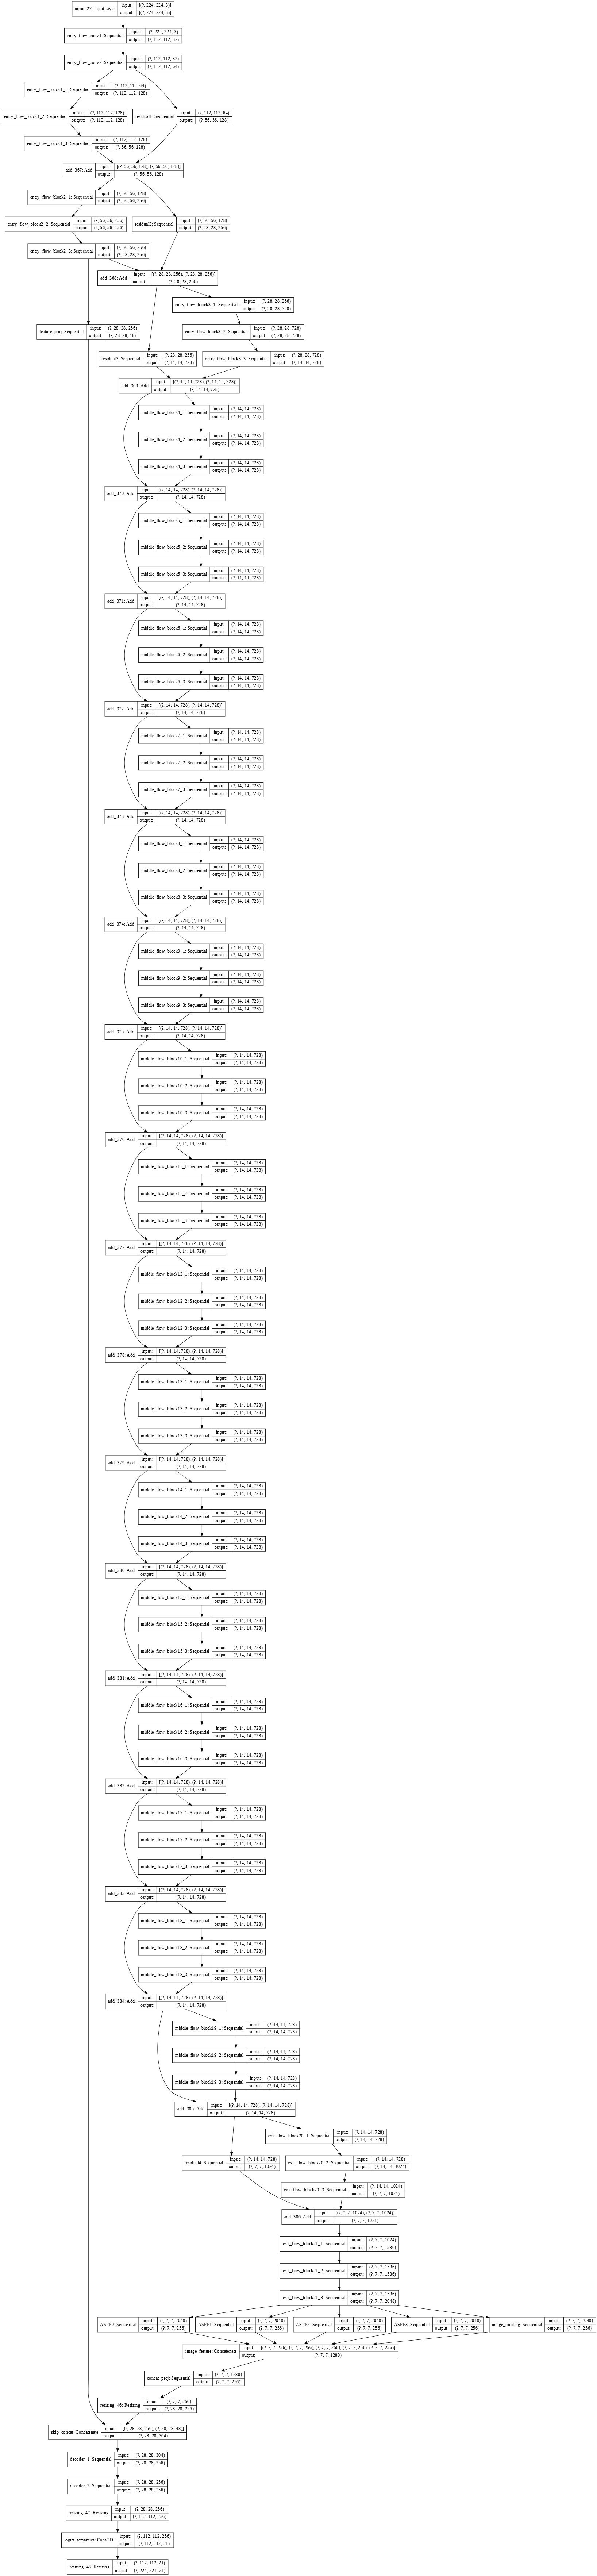

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
model.summary(line_length=150)

Model: "DeepLabv3+"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_26 (InputLayer)                            [(None, 224, 224, 3)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
entry_flow_conv1 (Sequential)                    (None, 112, 112, 32)             992               input_26[0][0]                                    
______________________________________________________________________________________________________________________________________________________
entry_flow_conv2 (Sequential)                    (None, 112, 112, 64)     